# Bitcoin Price Analysis

Here, my objective is to analyse the bitcoin daily price database obtained from: https://finance.yahoo.com/quote/BTC-USD/history/

Initially, the daily timeframe will be the only one taken into account. In the future, I intend to analyse other timeframes like weekly or monthly data.

### 1- Pre-processing with PySpark

1.1- Creating session and reading data

In [1]:
# Importing pyspark and creating a new session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("btc") \
    .getOrCreate()
    

24/05/23 21:16:21 WARN Utils: Your hostname, Jotunheim.local resolves to a loopback address: 127.0.0.1; using 192.168.100.20 instead (on interface en0)
24/05/23 21:16:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 21:16:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
csv_file_path = "Databases/BTC/btc_usd_daily_2014_2024.csv"
data = spark.read.csv(csv_file_path, header=True)
data

DataFrame[Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]

In [3]:
data.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)



In [4]:
data.show()

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2014-09-17|465.864014|468.174011|452.421997|457.334015|457.334015|21056800|
|2014-09-18|456.859985|456.859985|413.104004|424.440002|424.440002|34483200|
|2014-09-19|424.102997|427.834991|384.532013|394.795990|394.795990|37919700|
|2014-09-20|394.673004|423.295990|389.882996|408.903992|408.903992|36863600|
|2014-09-21|408.084991|412.425995|393.181000|398.821014|398.821014|26580100|
|2014-09-22|399.100006|406.915985|397.130005|402.152008|402.152008|24127600|
|2014-09-23|402.092010|441.557007|396.196991|435.790985|435.790985|45099500|
|2014-09-24|435.751007|436.112000|421.131989|423.204987|423.204987|30627700|
|2014-09-25|423.156006|423.519989|409.467987|411.574005|411.574005|26814400|
|2014-09-26|411.428986|414.937988|400.009003|404.424988|404.424988|21460800|

1.2- Converting columns to their respective types

In [5]:
# importing datatypes that will be used with this database
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import to_date

In [6]:
data = data.withColumnRenamed('Adj Close','AdjClose')

In [7]:
column_names = data.columns
column_names.remove('Date')
column_names

['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']

In [8]:
# Convert columns to DoubleType
for col_name in column_names:
    data = data.withColumn(col_name, col(col_name).cast(DoubleType()))

# Convert "Date" column to DateType
data = data.withColumn("Date", to_date(data["Date"], "yyyy-MM-dd"))

In [9]:
data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- AdjClose: double (nullable = true)
 |-- Volume: double (nullable = true)



In [10]:
data = data.orderBy(data['Date'])
data.show()

+----------+----------+----------+----------+----------+----------+-----------+
|      Date|      Open|      High|       Low|     Close|  AdjClose|     Volume|
+----------+----------+----------+----------+----------+----------+-----------+
|2014-09-17|465.864014|468.174011|452.421997|457.334015|457.334015|  2.10568E7|
|2014-09-18|456.859985|456.859985|413.104004|424.440002|424.440002|  3.44832E7|
|2014-09-19|424.102997|427.834991|384.532013| 394.79599| 394.79599|  3.79197E7|
|2014-09-20|394.673004| 423.29599|389.882996|408.903992|408.903992|  3.68636E7|
|2014-09-21|408.084991|412.425995|   393.181|398.821014|398.821014|  2.65801E7|
|2014-09-22|399.100006|406.915985|397.130005|402.152008|402.152008|  2.41276E7|
|2014-09-23| 402.09201|441.557007|396.196991|435.790985|435.790985|  4.50995E7|
|2014-09-24|435.751007|   436.112|421.131989|423.204987|423.204987|  3.06277E7|
|2014-09-25|423.156006|423.519989|409.467987|411.574005|411.574005|  2.68144E7|
|2014-09-26|411.428986|414.937988|400.00

### 2- Experiments

2.1- Ploting a 2024 price chart

In [11]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

First, I will plot the daily candle chart with moving average of 10, 30 and 60 days.

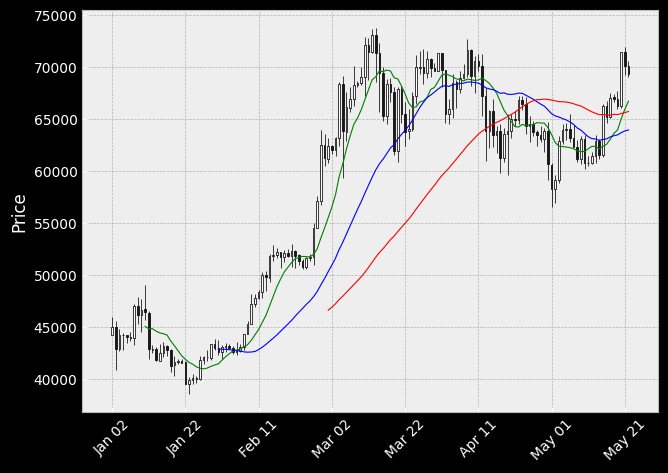

In [12]:
# Filtering current year data
current_year_data = data.where(data['Date'] > '2024-01-01')

# Changing style
mc = mpf.make_marketcolors(up='white',down='black')
style = mpf.make_mpf_style(base_mpl_style=['dark_background','bmh'],
                           marketcolors=mc, 
                           mavcolors=['green','blue','red'])

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = current_year_data.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
pandas_df.set_index('Date', inplace=True)
pandas_df.columns
mpf.plot(pandas_df, type='candle',mav=[10,30,60], style=style)

Now I will plot a line chart of all-time prices with moving average of 200 days. The y-axis will have a log scale.

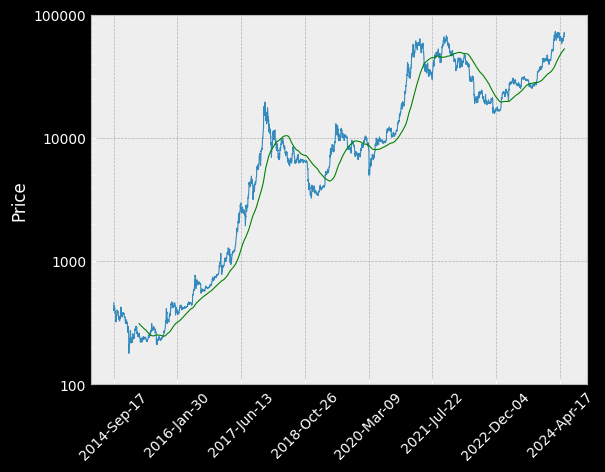

In [13]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = data.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

# Set 'Date' column as index
pandas_df.set_index('Date', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots()
mpf.plot(pandas_df, type='line',mav=[200],style=style, ax=ax)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Set y-axis limits from 100 to 100,000
ax.set_ylim(100, 100000)

# Use ScalarFormatter to display labels as plain numbers
ax.yaxis.set_major_formatter(ScalarFormatter())

# Add a legend indicating the year
years = pandas_df.index.year.unique()
for year in years:
    ax.plot([], [], label=str(year))

plt.show()


# 3- Analysis
### 1- Bitcoin network analysis

Bitcoin is an well known cryptocurrency created by the pseudonym Satoshi Nakamoto. The core idea is that the network produces X amount of new bitcoin each block. And every 210.000, X is divided by 2. Initially, each block generated 50 new bitcoin. After ever 210.000 blocks (about 4 years), it decreased to 25 bitcoin per block. First, we will define how this can happen from a mathematical point of view.

In [14]:
# Quantity of coins generated in the first block
start_amount = 50

# Number of blocks before each "halving"
blocks_between_halving = 210000

# Decreasing ratio
r = 0.5

Now that we have the main values. How this works mathematically? Lets go through this step by step.
First, we know that at the start, each block produces 50 bitcoin. So imagine that we have no ratio of decreasing. In that case, we would have a function (here I will call f(x) to simplify) like this:

\begin{equation}
f(x) = 50
\end{equation}

Looking at this equation, we can expect that doesn't matter which block we choose (represented by x), we will always have 50 generated bitcoin. But the reality is different. The actual network has a decreasing ratio every 210000 blocks. How can we write this down? We need a function that cuts by half the generation every 210000 blocks. Let's think,
In any block before 210000, I generate 50 bitcoin, so f(x) works perfectly for that case. After 210000 blocks, the network will produce 25 coins per block, that is, 50 divided by 2.

\begin{equation}
f(x) = \begin{cases} 
50 & \text{if } x < 210000 \\
50/2 & \text{if } x \geq 210000 
\end{cases}
\end{equation}

Now, we're closer. But can we make those two cases almost identical? Yes! In the first case, we can divide 50 by 2 elevated by 0. Every number elevated by 0 equals 1, so the function still the same, it is just written in another way.

\begin{equation}
f(x) = \begin{cases} 
50/2^0 & \text{if } x < 210000 \\
50/2^1 & \text{if } x \geq 210000 
\end{cases}
\end{equation}

Looking at these two cases, we can unite them in a more generic function. Think in the scale of bitcoin halvings, so before the first halving we would have an epoch with index "0", after the first halving the index would be "1" and so on. Imagine how the function we're trying to achieve would look if it was not about an specif block, but about an halving.
Then we would have something like this:

\begin{equation}
f(i) = 50/2^i
\end{equation}

Now, if we choose a halving index, the function will give us the amount of bitcoin genereted by each block after that halving. For example, after the 1st halving, we would have 50/2 = 25 coins. After the 4th, 50/16 = 3.125 coins per block. 

But the function we wanted return the coins generated by an specific block. In this case we need to "discover" in which halving the block "belongs". This is not difficult. If we have the number of the block (x) then we just need to divide the number by the interval between halvings, that is 210.000. If we choose block 345.000, for example, we should calculate 345.000/210.000 = 1.642. Now we just ignore everything after the collon. So block 345.000 is in the interval of block of the first halving. Therefore, it created 25 coins. Finally, the function we want is:

\begin{equation}
f(x) = 50/2^{\lfloor {x/210.000} \rfloor}
\end{equation}

If you are wondering how it would look in a chart, here it is:

In [15]:
import numpy as np
import math

# Function definition
def coins_generated_by_block(x):
    return 50 / 2 ** np.floor(x/210000)

In [16]:
# Blocks between epoch 0 and 9
x_values = np.linspace(0,1889999,1000)

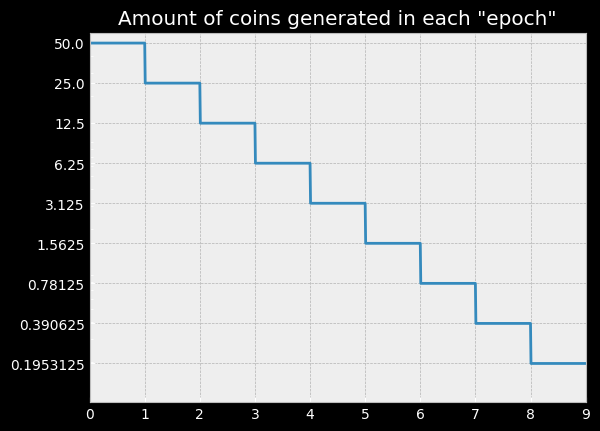

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys

smallest_positive_float = sys.float_info.min

# Create the plot
fig, ax = plt.subplots()
ax.plot(x_values, coins_generated_by_block(x_values))
ax.set_title('Amount of coins generated in each \"epoch\"')

# Define the desired x-ticks
x_ticks = [i for i in range(0,10*210000,210000)]
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(ticker.FixedFormatter([str(int(tick/210000)) for tick in x_ticks]))
ax.set_xlim(min(x_ticks), max(x_ticks))

# Set y-axis to log scale
ax.set_yscale('log')

# Define the desired y-ticks
y_ticks = [50/2**i for i in range(0,10)]
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(ticker.FixedFormatter([str(tick) for tick in y_ticks]))
ax.set_ylim(0.1, max(y_ticks) + 10)
plt.show()

In [18]:
def total_of_coins(block_list):
    bitcoins_created_list = []

    for block in block_list:
        blocks = np.arange(0,int(block))
        bitcoins_in_blocks = coins_generated_by_block(blocks) # 50 bitcoins per block initially
        total_bitcoins = np.sum(bitcoins_in_blocks)
        bitcoins_created_list.append(total_bitcoins)
        
    return bitcoins_created_list

In [19]:
total_of_coins = total_of_coins(x_values)

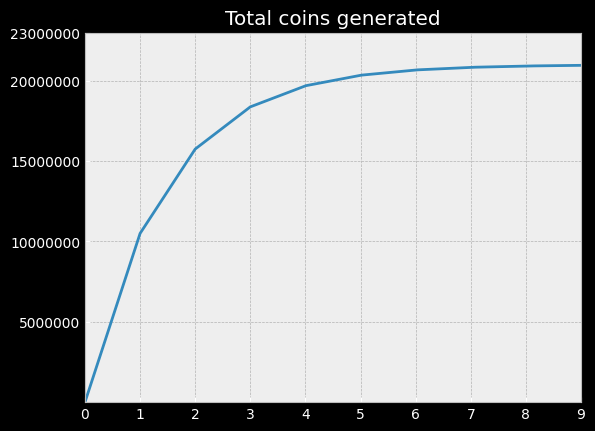

In [20]:
# Create the plot
fig, ax = plt.subplots()
ax.plot(x_values, total_of_coins)
ax.set_title('Total coins generated')

# Define the desired x-ticks
x_ticks = [i for i in range(0,10*210000,210000)]
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(ticker.FixedFormatter([str(int(tick/210000)) for tick in x_ticks]))
ax.set_xlim(min(x_ticks), max(x_ticks))

# Set y-axis to log scale
# ax.set_yscale('log')

# Define the desired y-ticks
y_ticks = [0,5000000,10000000,15000000,20000000, 23000000]
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(ticker.FixedFormatter([str(tick) for tick in y_ticks]))
ax.set_ylim(0.1, max(y_ticks) + 10)
plt.show()

Plotting the double plot

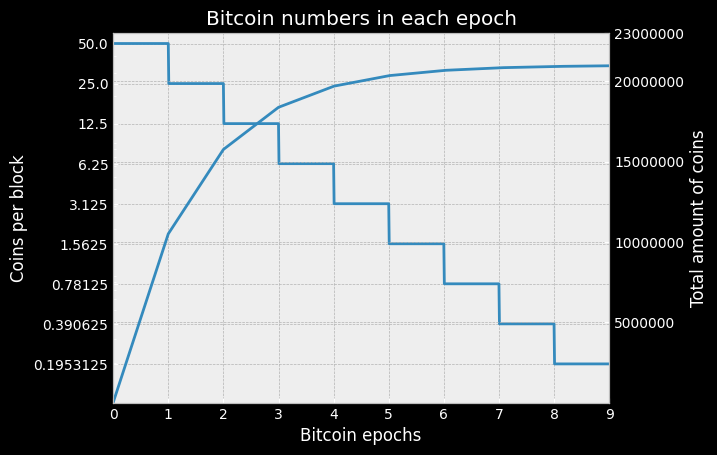

In [37]:

# Create the plot
fig, ax = plt.subplots()
ax.plot(x_values, coins_generated_by_block(x_values))
ax.set_title('Bitcoin numbers in each epoch')

# Define the desired x-ticks
x_ticks = [i for i in range(0,10*210000,210000)]
ax.set_xticks(x_ticks)
ax.set_xlabel('Bitcoin epochs')
ax.get_xaxis().set_major_formatter(ticker.FixedFormatter([str(int(tick/210000)) for tick in x_ticks]))
ax.set_xlim(min(x_ticks), max(x_ticks))

# Set y-axis to log scale
ax.set_yscale('log')

# Define the desired y-ticks
y_ticks = [50/2**i for i in range(0,10)]
ax.set_yticks(y_ticks)
ax.set_ylabel('Coins per block')
ax.get_yaxis().set_major_formatter(ticker.FixedFormatter([str(tick) for tick in y_ticks]))
ax.set_ylim(0.1, max(y_ticks) + 10)

y_ticks = [0,5000000,10000000,15000000,20000000, 23000000]
ax2 = ax.twinx()
ax2.plot(x_values, total_of_coins)
ax2.set_ylabel('Total amount of coins')
ax2.tick_params(axis='y')
ax2.set_yticks(y_ticks)
ax2.get_yaxis().set_major_formatter(ticker.FixedFormatter([str(tick) for tick in y_ticks]))
ax2.set_ylim(0.1, max(y_ticks) + 10)

plt.show()